In [1]:
import redis
r = redis.Redis()
import pickle
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# plot open vs date (training)
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=MSFT&outputsize=full&apikey=WIGVQ9248GZG5TU3&datatype=csv'

In [4]:
full = pd.read_csv(url)
full.shape

(5337, 9)

In [5]:
full.head()

,timestamp,open,high,low,close,adjusted_close,volume,dividend_amount,split_coefficient
0,2021-01-15,213.52,214.51,212.0300,212.65,212.65,31746512,0.0,1.0
1,2021-01-14,215.91,217.46,212.7400,213.02,213.02,29346737,0.0,1.0
2,2021-01-13,214.02,216.76,213.9266,216.34,216.34,20087080,0.0,1.0
3,2021-01-12,216.50,217.10,213.3202,214.93,214.93,23148341,0.0,1.0
4,2021-01-11,218.47,218.91,216.7300,217.49,217.49,23047029,0.0,1.0


In [6]:
train = full.head(int(full.shape[0]*0.7))
test = full.tail(int(full.shape[0]*0.3))

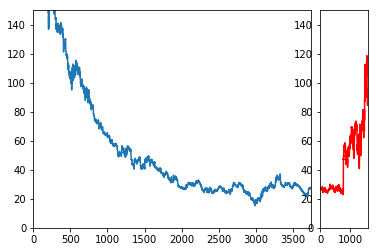

In [7]:
fg1 = plt.subplot2grid((1,6),(0,0), rowspan=1, colspan=5)
fg2 = plt.subplot2grid((1,6),(0,5), rowspan=1, colspan=1)

fg1.plot(train['open'].values)
fg1.set_xlim([0,train.shape[0]])
fg1.set_ylim([0,150])

fg2.plot(test['open'].values,color='red')
fg2.set_xlim([0,test.shape[0]])
fg2.set_ylim([0,150])

plt.show()

In [8]:
train_processed = train.iloc[:, 1:2].values
test_processed = test.iloc[:, 1:2].values
print(train_processed.shape,test_processed.shape)

(3735, 1) (1601, 1)


In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
train_scaled = scaler.fit_transform(train_processed)
test_scaled = scaler.fit_transform(test_processed)

In [10]:
print("Train\n",train_scaled,"\n---------------\nTest")
print(test_scaled)

Train
 [[0.92642594]
 [0.93759051]
 [0.92876162]
 ...
 [0.05955996]
 [0.0583454 ]
 [0.05689728]] 
---------------
Test
[[0.0455493 ]
 [0.04367313]
 [0.04345424]
 ...
 [0.73097769]
 [0.72899729]
 [0.73420888]]


In [11]:
features_set = []  
labels = []
for i in range(60, train_scaled.shape[0]):  
    features_set.append(train_scaled[i-60:i,0])
    labels.append(train_scaled[i,0])

features_set, labels = np.array(features_set), np.array(labels)  

features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1)) 

pickled_object = pickle.dumps(features_set)

### Store Feature Set in Redis

In [12]:
r.set('features_set', pickled_object)

True

### Retrieve Feature Set from Redis

In [13]:
features_set = pickle.loads(r.get('features_set'))

### Define Layers in the model

In [14]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(features_set.shape[1], 1)))  
model.add(Dropout(0.2))  
model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))  
model.add(Dropout(0.2))

model.add(LSTM(units=50))  
model.add(Dropout(0.2))  

model.add(Dense(units = 1)) 
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [15]:
model.fit(features_set, labels, epochs = 10, batch_size = 32) 

Train on 3675 samples
Epoch 1/10
3675/3675 [==============================] - 27s 7ms/sample - loss: 0.0039
Epoch 2/10
3675/3675 [==============================] - 17s 5ms/sample - loss: 0.0013
Epoch 3/10
3675/3675 [==============================] - 19s 5ms/sample - loss: 0.0011
Epoch 4/10
3675/3675 [==============================] - 18s 5ms/sample - loss: 9.1273e-04
Epoch 5/10
3675/3675 [==============================] - 19s 5ms/sample - loss: 9.2254e-04
Epoch 6/10
3675/3675 [==============================] - 20s 5ms/sample - loss: 9.4036e-04
Epoch 7/10
3675/3675 [==============================] - 23s 6ms/sample - loss: 9.4570e-04
Epoch 8/10
3675/3675 [==============================] - 18s 5ms/sample - loss: 9.2472e-04
Epoch 9/10
3675/3675 [==============================] - 20s 5ms/sample - loss: 8.5510e-04
Epoch 10/10
3675/3675 [==============================] - 18s 5ms/sample - loss: 9.4930e-04


### Save and Load Model

In [16]:
from tensorflow.keras.models import load_model

model.save('./saved_models/stocks.h5')

In [17]:
model = load_model('./saved_models/stocks.h5')

test_features = []  
for i in range(60, test_scaled.shape[0]):  
    test_features.append(test_scaled[i-60:i, 0])

test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))  

pickled_object = pickle.dumps(features_set)

### Store Test Features in Redis

In [18]:
r.set('test_features', pickled_object)

True

### Get Test Features from Redis

In [ ]:
test_features = pickle.loads(r.get('features_set'))

In [ ]:
predictions = model.predict(test_features)  
print("Test\n",test_scaled,"\n---------------\nPredict")
print(predictions)

In [ ]:
scaler.inverse_transform(predictions) 

In [ ]:
plt.figure(figsize=(10,6))  
plt.plot(test_scaled, color='blue', label='Actual Stock Price')  
plt.plot(predictions, color='red', label='Predicted Stock Price')  
plt.title('Stock Price Prediction')  
plt.xlabel('Date')  
plt.ylabel('Stock Price')  
plt.legend()  
plt.show()

In [ ]:
model.predict(np.array([test_features[0]]))